In [1]:
def read_results(db, count, cmd, repeat):
    results = {}
    with open(f"results/{db}-{count}-{cmd}-{repeat}", "r") as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            if line.startswith("Total"):
                results["total"] = float(line.split()[1])
            if line.startswith("Slowest"):
                results["slowest"] = float(line.split()[1])
            if line.startswith("Fastest"):
                results["fastest"] = float(line.split()[1])
            if line.startswith("Average"):
                results["average"] = float(line.split()[1])
            if line.startswith("Stddev"):
                results["stddev"] = float(line.split()[1])
            if line.startswith("Requests/sec"):
                results["rps"] = float(line.split()[1])
            if line.startswith("10%"):
                results["p10"] = float(line.split()[2])
            if line.startswith("25%"):
                results["p25"] = float(line.split()[2])
            if line.startswith("50%"):
                results["p50"] = float(line.split()[2])
            if line.startswith("75%"):
                results["p75"] = float(line.split()[2])
            if line.startswith("90%"):
                results["p90"] = float(line.split()[2])
            if line.startswith("95%"):
                results["p95"] = float(line.split()[2])
            if line.startswith("99%"):
                results["p99"] = float(line.split()[2])
            if line.startswith("99.9%"):
                results["p999"] = float(line.split()[2])
                
    return results

In [2]:
import os

results = {}

for file in os.listdir("results"):
    db, count, cmd, repeat = file.split("-")
    if db not in results:
        results[db] = {}
    if int(count) not in results[db]:
        results[db][int(count)] = {}
    if cmd not in results[db][int(count)]:
        results[db][int(count)][cmd] = []
    results[db][int(count)][cmd].append(read_results(db, count, cmd, repeat))
    
results

{'eckd': {9: {'put': [{'total': 2.9308,
     'slowest': 0.1704,
     'fastest': 0.0002,
     'average': 0.0219,
     'stddev': 0.016,
     'rps': 34120.6931,
     'p10': 0.0065,
     'p25': 0.0118,
     'p50': 0.0187,
     'p75': 0.0276,
     'p90': 0.039,
     'p95': 0.0499,
     'p99': 0.0877,
     'p999': 0.132},
    {'total': 2.8561,
     'slowest': 0.1422,
     'fastest': 0.0003,
     'average': 0.0218,
     'stddev': 0.0139,
     'rps': 35012.7526,
     'p10': 0.0073,
     'p25': 0.0121,
     'p50': 0.0195,
     'p75': 0.0281,
     'p90': 0.0379,
     'p95': 0.0457,
     'p99': 0.0728,
     'p999': 0.1046},
    {'total': 2.8736,
     'slowest': 0.1129,
     'fastest': 0.0002,
     'average': 0.0214,
     'stddev': 0.0131,
     'rps': 34799.4,
     'p10': 0.0067,
     'p25': 0.0123,
     'p50': 0.0194,
     'p75': 0.0275,
     'p90': 0.0375,
     'p95': 0.0468,
     'p99': 0.0645,
     'p999': 0.0844}],
   'range_s': [{'total': 1.9924,
     'slowest': 0.0808,
     'fastest': 0.000

In [3]:
averaged_results = {}

for db in results.keys():
    averaged_results[db] = {}
    for count in results[db].keys():
        averaged_results[db][count] = {}
        for cmd in results[db][count].keys():
            averaged_results[db][count][cmd] = {}
            for key in results[db][count][cmd][0]:
                averaged_results[db][count][cmd][key] = sum([x[key] for x in results[db][count][cmd] if key in x]) / len(results[db][count][cmd])

results = averaged_results

In [4]:
dbs = ["etcd", "eckd"]
if "etcd" in results:
    etcd_counts = sorted([k for (k,v) in results["etcd"].items() if v])
if "eckd" in results:
    eckd_counts = sorted([k for (k,v) in results["eckd"].items() if v])

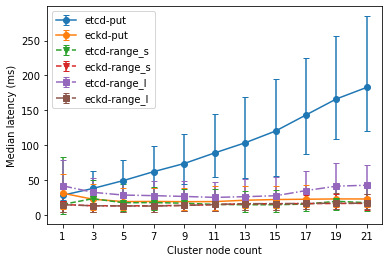

In [5]:
import matplotlib.pyplot as plt

plt.rc("errorbar", capsize=3)

markers = ["o", "v", "s"]
linestyles = ["-", "--", "-."]

plt.figure()

def plot(db, counts, cmd, num):
    ys = [results[db][c][cmd].get("p50", None) * 1000 for c in counts]
    yerr_lower = [(results[db][c][cmd]["p90"] - results[db][c][cmd]["p50"])*1000 for c in counts]
    yerr_upper = [(results[db][c][cmd]["p50"] - results[db][c][cmd]["p10"])*1000 for c in counts]

    plt.errorbar(counts, ys, yerr=[yerr_upper, yerr_lower], label=f"{db}-{cmd}", marker=markers[num], linestyle=linestyles[num])

for i, cmd in enumerate(["put", "range_s", "range_l"]):
    if "etcd" in results:
        plot("etcd", etcd_counts, cmd, i)
    if "eckd" in results:
        plot("eckd", eckd_counts, cmd, i)

plt.legend()

plt.ylabel("Median latency (ms)")
plt.xlabel("Cluster node count")

plt.xticks(etcd_counts)

plt.savefig("latency.pdf")

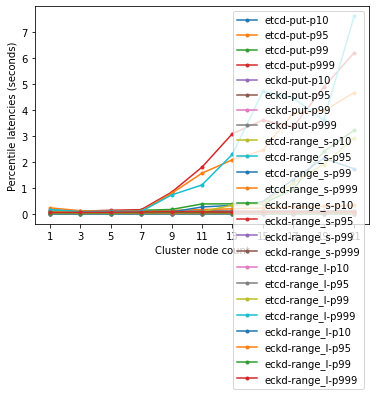

In [6]:
import matplotlib.pyplot as plt

plt.figure()

def plot(db, counts, cmd):
    for p in [10, 95, 99, 999]:
        ys = [results[db][c][cmd].get(f"p{p}", None) for c in counts]
        plt.plot(counts, ys, label=f"{db}-{cmd}-p{p}", marker=".")

for cmd in ["put", "range_s", "range_l"]:
    if "etcd" in results:
        plot("etcd", etcd_counts, cmd)
    if "eckd" in results:
        plot("eckd", eckd_counts, cmd)
    
plt.legend()

plt.ylabel("Percentile latencies (seconds)") 
plt.xlabel("Cluster node count")

plt.xticks(etcd_counts)

plt.savefig("percentiles.pdf")

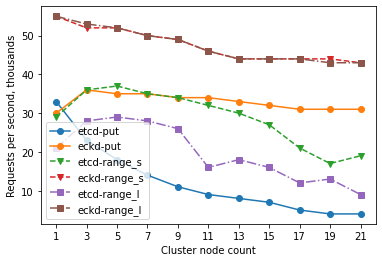

In [7]:
import matplotlib.pyplot as plt

plt.figure()

def plot(db, counts, cmd, marker):
    ys = [results[db][c][cmd].get("rps", None) // 1000 for c in counts]
    plt.plot(counts, ys, label=f"{db}-{cmd}", marker=markers[i], linestyle=linestyles[i])

for i, cmd in enumerate(["put", "range_s", "range_l"]):
    if "etcd" in results:
        plot("etcd", etcd_counts, cmd, i)
    if "eckd" in results:
        plot("eckd", eckd_counts, cmd, i)
    
plt.legend()

plt.ylabel("Requests per second, thousands") 
plt.xlabel("Cluster node count")

plt.xticks(etcd_counts)

plt.savefig("throughput.pdf")

In [68]:
# Stats results

import json
from collections import defaultdict 

def stats_from_log_files(file):
    stats = defaultdict(int)
    with open(file, 'r') as f:
        for line in f.readlines():
            if "tracing" in line:
                j = line.strip().split("Ok")[-1][1:-1]
                try:
                    j = json.loads(json.loads(j))
                except:
                    continue
                
                if "tracing range" in line:
                    stats["range"] += 1
                elif "tracing txn" in line:
                    for s in j["success"]:
                        s = s["request"]
                        if "RequestPut" in s:
                            stats["txn_success_put"] += 1
                        elif "RequestDeleteRange" in s:
                            stats["txn_success_delete_range"] += 1
                        else:
                            print(s)
                    for s in j["failure"]:
                        s = s["request"]
                        if "RequestPut" in s:
                            stats["txn_failure_put"] += 1
                        elif "RequestDeleteRange" in s:
                            stats["txn_failure_delete_range"] += 1
                        elif "RequestRange" in s:
                            stats["txn_failure_request_range"] += 1
                        else:
                            print(s)
                    stats["txn"] += 1
                elif "tracing lease_grant" in line:
                    stats["lease_grant"] += 1
                elif "tracing watch_create" in line:
                    stats["watch_create"] += 1
                else:
                    print(line)
                    
    return stats
        
import glob
import os

stats_logs = []

dirs = glob.glob("../stats*")
dirs.sort()
d = dirs[-1]

for file in os.listdir(d): # use latest
    stats_logs.append(stats_from_log_files(f"{d}/{file}"))

combined_stats = defaultdict(list)
for s in stats_logs:
    for k, v in s.items():
        combined_stats[k].append(v)
        
avg_stats = {}
for k, l in combined_stats.items():
    avg_stats[k] = sum(l) / len(l)
    
avg_stats

{'range': 1542.1,
 'watch_create': 67.0,
 'txn_success_put': 865.7,
 'txn_failure_request_range': 476.3,
 'txn': 876.5,
 'lease_grant': 12.3,
 'txn_success_delete_range': 12.0}